# From Correlation to Supervised Segmentation
_Summary:_ In this notebook we introduce one of the main topics in data science: predictive modelling. We focus on one application known as supervised segmentation, namely how to split a population (e.g. of customers) into groups that differ according to a quantity of interest. For example, we might want to know which groups of customers are most profitable. One outcome of exploring supervised segmentation is that we'll learn about:

* Finding or selecting important, informative variables or "attributes"
* Segmenting data by progressive attribute selection

Selecting informative attributes forms the basis of _tree structured models_, which recusrively find attributes for subsets of the data. These models will form the second part of this notebook where we provide an introduction to the [scikit-learn](https://scikit-learn.org/stable/) library for machine learning.

## Customer Churn

<br>
<img src='./images/churn.png'>


As an explicit example we will continue to explore [IBM's telecommunications dataset](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/) and determine which attributes are most informative for predicting customer retention (also known as customer churn). As described by IBM, the problem setting is as follows:

> A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer (tenure), contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, whether they're a senior citizen or not, and if they have partners and dependents

The kind of questions we'd like to find answers to are:

* Which customers are likely to leave?
* Which attributes influence customers who leave?


You should already have the dataset from Assignment 1, but if not you can download it from the IBM link above or from [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn).

_Created by:_ Lewis Tunstall, Spring 2019

_Sources:_ 

* Chapter 3 of _Data Science for Business_ by Provost and Fawcett
* [Chapter 5 of _Python Data Science Handbook_ by VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.00-machine-learning.html)
* [Decision Tree Classification in Python](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
* [Creating and Visualizing Decision Trees with Python](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)

## Load libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2

In [2]:
# data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
from utils import print_categories

from IPython.display import Image
import graphviz
from sklearn.tree import export_graphviz

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# these commands define the color scheme
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('muted'))

## Load data
As usual, we make use of the pathlib library to handle our filepaths:

In [3]:
DATA_PATH = Path('./data/')
!ls {DATA_PATH}

beers.csv              cancer.csv             titanic
breweries.csv          churn.csv              world-happiness-report


In [4]:
df = pd.read_csv(DATA_PATH.joinpath('churn.csv')); df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Inspect the data

### The shape of data

In [5]:
# your code here
df.shape

(7043, 21)

In this case, we see that we have 7043 customers and 21 variables or attributes that describe their subscription. Let's have a look at the columns:

In [6]:
# your code here
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

As explained in the summary, the _**target attribute**_ is `Churn` and thus we have a _**classification problem**_ (rather than regression) because the target is a _**category**_ (Yes or No) rather than a number.

### Unique values
Whenever we see an ID column like `customerID`, it is useful to perform a sanity check that each value is unique. Otherwise it may be possible that you have duplicates in your data that can bias your models and hence conclusions. 

In [7]:
# your code here
df['customerID'].nunique()

7043

Good! The number of unique IDs matches the number of rows in our DataFrame :) Since the customer IDs are all unique, there is unlikely to be useful information to be gained from this column so we drop it:

In [8]:
# your code here
df.drop('customerID', axis=1, inplace=True)

### Data types
Let's now use out `print_categories` function from `utils.py` to get an overview about the data types we expect in our data:

In [9]:
# your code here
print_categories(df)

gender : Categorical
SeniorCitizen : Numeric
Partner : Categorical
Dependents : Categorical
tenure : Numeric
PhoneService : Categorical
MultipleLines : Categorical
InternetService : Categorical
OnlineSecurity : Categorical
OnlineBackup : Categorical
DeviceProtection : Categorical
TechSupport : Categorical
StreamingTV : Categorical
StreamingMovies : Categorical
Contract : Categorical
PaperlessBilling : Categorical
PaymentMethod : Categorical
MonthlyCharges : Numeric
TotalCharges : Categorical
Churn : Categorical


## Data preprocessing

### Fill missing values
Hmm, `TotalCharges` is of type **object** (i.e. string) even though it is clearly a float. Since null values or NaNs don't produce this behaviour, there are presumably empty strings lurking in this column. Let's test this hypothesis:

In [10]:
# your code here
' ' in df['TotalCharges'].values

True

OK, let's now replace these values with NaNs and fill them with the median:

In [11]:
# your code here
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype('float')
median = df['TotalCharges'].median()
df['TotalCharges'].fillna(value=median, inplace=True)
# check data type is really a float
df['TotalCharges'].dtype

dtype('float64')

---
**You should know**

Most machine learning algorithms cannot work with missing features, and in general you have three options to handle them:
* Get rid of the corresponding rows.
* Get rid of the whole attribute (i.e. columns).
* Set the missing values to some value (zero, mean, median, etc)

Above we used an example of option 3 - to accomplish the other two options you can use the `dropna` and `drop` methods:
```
df.dropna(subset=['TotalCharges']) # option 1
df.drop('TotalCharges', axis=1) # option 2
```
---

### Convert objects to categorical
pandas has a special `Categorical` type for holding data that uses the integer-based categorical representation or **_encoding_**. For example `df['gender']` is a `Series` of Python string objects (Female and Male). We can convert a `DataFrame` column to categorical as follows:
```
df['gender'] = df['gender'].astype('category')
```
The resulting `Categorical` object has `categories` and `codes` attributes that can be accessed as follows:
```
df['gender'].cat.categories
df['gender'].cat.codes
```
Why do we do this? The main motivation is that machine learning algorithms are best suited for doing computations on arrays of numbers, not strings, so some method to map strings to numbers is needed. 

With `TotalCharges` now of the correct type, let's convert the remaining object types and the `SeniorCitizen` column to Categorical type:

In [12]:
for col in df.columns:
    if df[col].dtype == 'O' or col == 'SeniorCitizen':
        df[col] = df[col].astype('category')

### Discretise the tenure attribute
Continuous data is often discretised or separated into "bins" for analysis. This is typically done when you want to group people into discrete age buckets or in the case of our data, discrete `tenure` buckets. Let's have a look at the distribution of `tenure` values to get an idea about how to discretise the data:

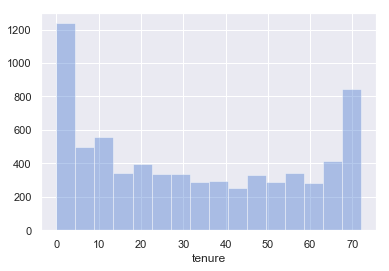

In [13]:
# your code here
sns.distplot(df['tenure'], kde=False)
plt.show()

From the plot, we could reasonably divide the `tenure` values into bins of 0 to 6, 7 to 20, 21 to 40, 41 to 60, and finally 61 and over. To do so we use the `cut` function from pandas: 

In [14]:
bins = [0, 6, 20, 40, 60, 100]
group_names = ['<=6', '7-20', '21-40', '41-60', '60+']
df['tenure_cats'] = pd.cut(df['tenure'], bins, labels=group_names, include_lowest=True)

Note that the object pandas returns is also a special `Categorical` object. We can also examine the value counts:

In [15]:
df['tenure_cats'].value_counts()

<=6      1481
21-40    1408
60+      1407
7-20     1397
41-60    1350
Name: tenure_cats, dtype: int64

Finally let's drop the `tenure` column since it's redundant:

In [16]:
# your code here
df.drop('tenure', axis=1, inplace=True)

## Selecting informative attributes
In general, a predictive model attempts to estimate the value of some particular target variable of interest (in our case the `Churn` variable). The key idea is to segment the population into subgroups that have different values for the target variable. In our example, the predictive model can be framed in terms of the following quesions:

* What are the best segments for predicting the propensity to churn?
* How can we judge whether a variable contains important information about the target? How much?

Thus our goal is to automatically select the most informative variables and ranks them by how good they are at predicting the target.

### Entropy
Our task is to predict or estimate the `Churn` target in our data. This is a binary classification problem (two classes, Yes and No), where the goal is to segment the customers into groups in a way that distinguishes those who are likely to churn from those who are not.

One way to evaluate how well each attribute splits the data with respect to the target variable is to use a so-called _purity measure_. The most common splitting criterion is known as **_information gain_** and is based on a purity measure known as **_entropy_**.

Conceptually, entropy is a measure of **_disorder_** which corresponds to how mixed or impure a segment is with respect to the properties of interest. Technically, entropy is defined as

$$ entropy = -p_1 \log_2(p_1) - p_2\log_2(p_2) - \ldots $$

where each $p_i$ is the probability of property $i$ within the set and $log_2(x)$ is the base 2 logarithm. In general, $p_i=1$ when all elements of the set have the same property, while $p_i=0$ when no elements have the same property. An example of the information gain for a set of 10 instances and two classes $+$ and $-$ is shown in the figure below.

<br>
<img src='./images/entropy.png' width='500'>
<p style="text-align: center;"> <b>Figure:</b> Entropy of a two-class set as a function of $p(+)$. </p>


### Exercise
Calculate the probabilities of churn and no churn from our dataset and use these to calculate the entropy of the target attribute. Hint: you may find NumPy's `np.log2(x)` function is useful here.

In [17]:
# your code here
probs = df['Churn'].value_counts(normalize=True).to_dict()

p_churn = probs['Yes']
p_no_churn = probs['No']

entropy_churn = -p_churn * np.log2(p_churn) - p_no_churn * np.log2(p_no_churn); entropy_churn

0.8347419473972113

For later use, we define below a general function that can be used to calculate the entropy of any set:

In [18]:
def entropy(target):
    '''A helper function to calculate the entropy associated with the target column of a DataFrame.
    
    Args:
        target: A pandas Series object corresponding to the target of interest.
        
    Returns:
        entropy (float): The entropy over the target.
    '''
    # get the number of instances / rows
    n = len(target)
    # count how frequently each unique target value occurs
    counts = target.value_counts().values 
    # initialize entropy
    entropy = 0
    
    # for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            prob = count / n
            # use base 2 logarithm for entropy definition
            entropy += np.log2(prob) * prob
            
    # minus sign is part of the definition
    return - 1. * entropy

In [19]:
# sanity check that we get the same answer as before
entropy(df['Churn'])

0.8347419473972113

### Information gain
Although entropy gives us a measure of how impure a given segment is, we are mroe interested in knowing how _informative_ a given attribute (e.g. gender, age, income) is with respect to the target variable. The way to measure this is via **_information gain (IG)_** which measures how much a given attribute _decreases_ entropy over the segmentation.

Given an attribute with $k$ different values (e.g. $k=2$ for gender), we can split the parent set on $k$ children sets, calculate the entropy on each child and examine the _change_ in entropy:

$$ IG(parent, children) = entropy(parent) - [p(c_1) \times entropy(c_1) + p(c_2) \times entropy(c_2) + \ldots ] \,.$$

Roughly speaking, the larger the information gain for a given attribute, the greater the reduction in entropy and thus the greater amount of information it provides about the target. An example of how the information gain is calculated across different splits is shown in the figure below.

<br>
<img src='./images/information-gain-3.png' width='1000'>
<p style="text-align: center;"> <b>Figure:</b> Splitting a population into 2 and 3 segments, based on two different attributes. </p>


We can create a function to calculate the information gain as follow:

In [20]:
def information_gain(entropy_parent, column, target):
    '''A helper function to calculate the information gain for a segmentation over a specified column.
    
    Args:
        entropy_parent (float): The entropy of the parent set.
        column (str): The name of a pandas DataFrame column.
        
    Returns:
        info_gain (float): The information gain.
    '''

    entropy_child = []
    p_child = []

    for el in df[column].unique():
        entropy_child.append(entropy(df.loc[df[column] == el][target]))
        p_child.append(len(df.loc[df[column] == el]) / len(df))
        
    info_gain = entropy_parent - np.dot(entropy_child, p_child)
    
    return round(info_gain, 3)

## Attribute selection with information gain
We can now use our `information_gain` function to determin with attribute in the churn dataset is most informative. In particular we can rank each of the columns by their information gain. In practice this allows us to focus on a smaller set of variables when building a model and can also help us understand the data better.

### Exercise
Use the `information_gain` function to calculate the information gain for each _categorical_ column in `df`. Sort the values from largest to smallest and plot them as a bar plot. Hint: you may find the pandas functions `select_dtypes` and `sort_values` to be useful. For the bar plot you can look at seaborn's `barplot`. What are the top 3 drivers of churn?

In [21]:
information_gain(entropy_churn, 'Contract', 'Churn')

0.142

In [23]:
information_gain(entropy_churn, 'tenure_cats', 'Churn')

0.1

In [24]:
information_gain(entropy_churn, 'OnlineSecurity', 'Churn')

0.093

In [25]:
rank_info_gain = []

for col in df.select_dtypes(include='category').drop('Churn', axis=1).columns:
    rank_info_gain.append({'Attribute': col, 'Information Gain': information_gain(entropy_churn, col, 'Churn')}) 

In [26]:
df_info_gain = pd.DataFrame.from_dict(rank_info_gain).sort_values(by='Information Gain', ascending=False)

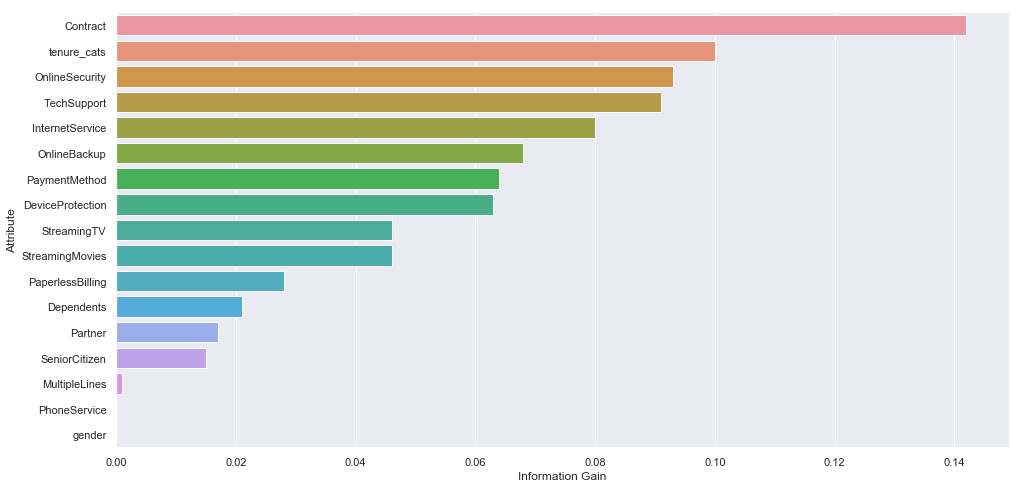

In [27]:
plt.figure(figsize=(16,8))
sns.barplot(x='Information Gain', y='Attribute', data=df_info_gain)
plt.show()

### Visualise the attributes
Once we have identified the top 3 drivers of churn, it is always a good idea to visualise the distribution of classes (i.e. churn vs no churn) in each category. This often gives us a nice insight into which subset of customers are most likely to cancel a subscription.

### Exercise
Create count plots of the distribution of churn values across the top 3 drivers identified in the previous exercise. Hint: you may find your work from Assignment 1 useful here.

In [28]:
def churn_plot(column):
    sns.countplot(x=column, hue='Churn', data=df)
    # place the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Churn')
    plt.show()

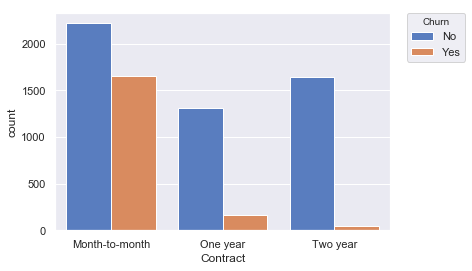

In [29]:
churn_plot('Contract')

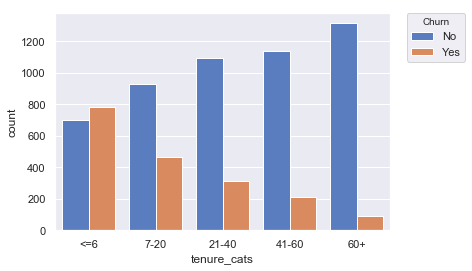

In [30]:
churn_plot('tenure_cats')

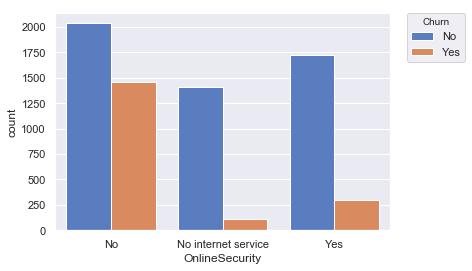

In [31]:
churn_plot('OnlineSecurity')

## Addressing churn prediction with classification trees
Now that we know which _individual_ variables provide the highest information gain (i.e. are the most predictive), we now consider the effect of _combinations_ of variables on the entropy. Since we have a classification problem (we need to predict the `Churn` labels which are discrete categories), we will use a tree model known as a **_decision tree_** to automatically determine which combinations of features are most important. These models provide an elegant way to perform multivariate (multiple attribute) supervised segmentation.

## Introducing scikit-learn
scikit-learn is one of the best known Python libraries for machine learning and provides efficient implementations of a large number of common algorithms. It has a uniform _Estimator API_ as well as excellent online documentation. The main benefit of its API is that once you understand the basic use and syntax of scikit-learn for one type of model, switching to a new model or algorithm is very easy.

### Basics of the API
The most common steps one takes when building a model in scikit-learn are:
1. Choose a class of model by importing the appropriate estimator class from scikit-learn.
2. Choose model _hyperparameters_ by instantiating this class with the desired values.
3. Arrange data into a features matrix and target vector (see discussion below).
4. Fit the model to your data by calling the `fit()` method.
5. Apply the model to new data:
    * For supervised learning we typically predict _labels_ for new data using the `predict()` method.
    * For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` methods.
    
Let's go through each of these steps to build a decision tree model to predict churn.

### Step 1: Choose a model
In scikit-learn, every class of model is represented by a Python class. We want a decision tree so looking at the online [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) we should import the `DecisionTreeClassifier`:

In [32]:
from sklearn.tree import DecisionTreeClassifier

### Step 2: Choose hyperparameters
Once we have chosen our model class, there are still some options open to us:
* What criterion do we want to use to measure the quality of the splits? The default is called the Gini impurity, but we actually want to use entropy for the information gain.
* What is the maximum depth of the tree? The default is `None` which means the nodes are expanded until all leaves are pure. In general this is not a good idea (it leads to something called _overfitting_ that we'll cover later), so let's pick a starting value of depth 3.
* Other parameters can be found in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), but for now we take the defaults.

The above choices are often referred to as _hyperparameters_ or parameters that must be set before the model is fit to the data. We can instantiate the `DecisionTreeClassifier` class and specify the desired hyperparameters as follows:

In [33]:
model = DecisionTreeClassifier(max_depth=3, criterion='entropy')
# display the full set of hyperparameters
model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Step 3: Arrange data into a features matrix and target vector
scikit-learn requires that the data be arranged into a two-dimensional features matrix and a one-dimensional target array. By convention, the features matrix is often stored in a variable called `X` This matrix is typically two-dimensional with shape `[n_samples, n_features]`, where `n_samples` refers to the number of row (i.e. customers in our example) and `n_features` refers to all columns except `Churn` which is our target. By convention, the target or label array is usually denoted by `y`.

To prepare the data for scikit-learn's API we first need to convert the categorical labels to their corresponding numerical codes:

In [34]:
for col in df.select_dtypes(include='category'):
    df[col] = df[col].cat.codes

In [35]:
# check that all data types are numeric
df.dtypes

gender                 int8
SeniorCitizen          int8
Partner                int8
Dependents             int8
PhoneService           int8
MultipleLines          int8
InternetService        int8
OnlineSecurity         int8
OnlineBackup           int8
DeviceProtection       int8
TechSupport            int8
StreamingTV            int8
StreamingMovies        int8
Contract               int8
PaperlessBilling       int8
PaymentMethod          int8
MonthlyCharges      float64
TotalCharges        float64
Churn                  int8
tenure_cats            int8
dtype: object

In [36]:
X = df.drop(['Churn'], axis=1)
X.shape

(7043, 19)

In [37]:
y = df['Churn']
y.shape

(7043,)

### Step 4: Fit the model to your data
Now it is time to apply our model to data! This can be done with the `fit()` method:

In [38]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Now that the model is trained, we can export the tree in [Graphviz](http://www.graphviz.org/) format. Below is a function that achieves this:

In [39]:
def visualise_tree(model, feature_names, class_names, proportion=True):
    '''A helper function to visualise decision tree classifiers.
    
    Args:
        model: A pre-trained scikit-learn model class for a decision tree regressor or classifier.
        feature_names (list): List of strings with the feature names.
        class_names (list): Names of each of the target classes in ascending numerical order.
        proportion (bool): Return fractions of members in each node or not.
    '''
    # export model information to dot object
    dot_data = export_graphviz(model, 
                    out_file=None, 
                    filled=True, rounded=True, 
                    special_characters=True,
                    feature_names = feature_names, 
                    proportion=proportion, 
                    class_names=class_names)
    # store dot object as a graph
    graph = graphviz.Source(dot_data)
    # display the graph in Jupyter
    display(Image(graph.pipe(format='png')))

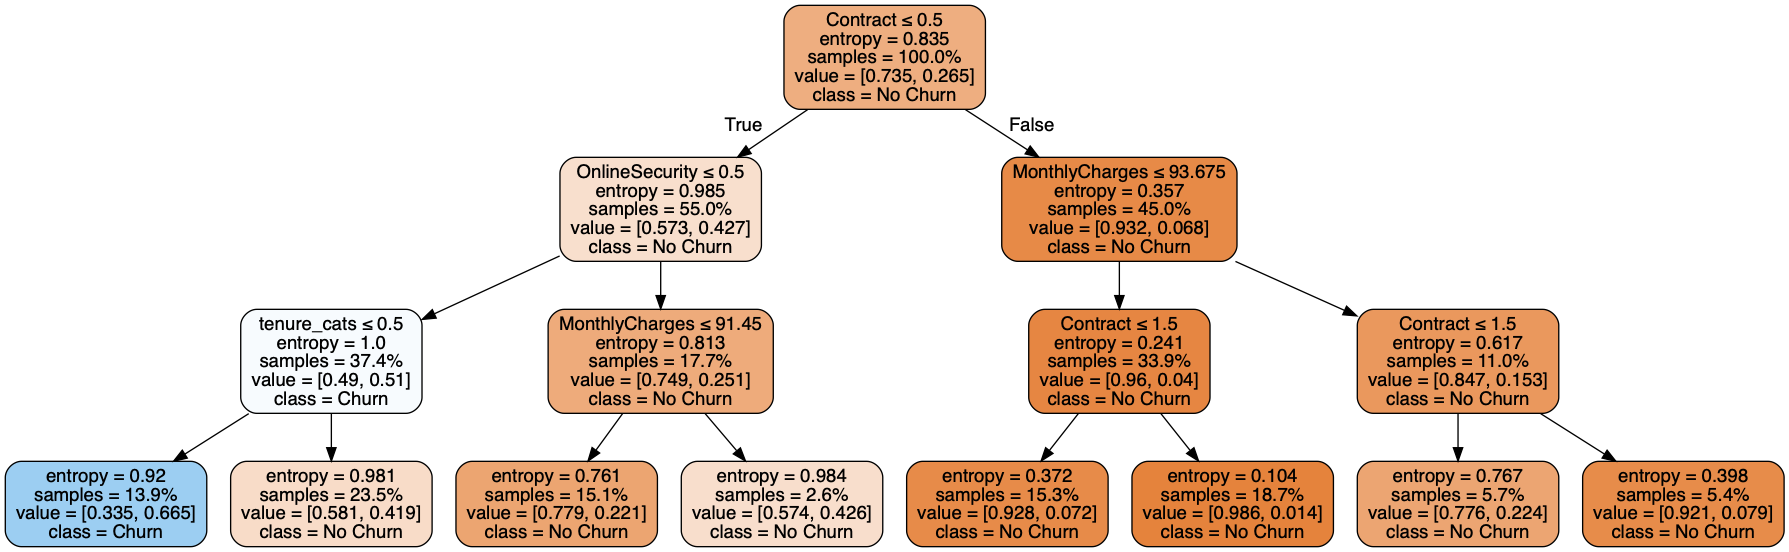

In [40]:
visualise_tree(model, X.columns, ['No Churn','Churn'], True)

In the tree plot, each node contains the condition (if/else rule) that splits the data, along with a series of other metrics of the node: 

* `entropy` refers to the impurity, a measure of the impurity of the node, i.e. how homogeneous are the samples within the node. We say that a node is pure when all its samples belong to the same class. In that case, there is no need for further split and this node is called a leaf. 
* `samples` is the number of instances in the node, while the value array shows the distribution of these instances per class. 
* `value` is a list of the fraction of members in each node with `['No Churn', 'Churn']`. You can change `proportion=False` in `visualise_tree` to get the result as a raw values.
* `class` denotes which fraction of `Churn` or `No Churn` is largest. When the `filled` option of export_graphviz is set to `True` each node gets colored according to the majority class.

### Exercise
Given the sample

In [41]:
with pd.option_context('max_columns', 100):
    display(X.sample(random_state=42))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_cats
185,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,24.8,24.8,0


can you use the tree above to estimate whether the sample's attributes indicate he/she is likely to churn?

### Step 5: Predict labels on unknown data
We will cover this step in more detail in the next 2 lessons, but for now we can mock the process by taking a random sample from our original data:

In [42]:
mock_new_data = X.sample(n=10, random_state=42); mock_new_data

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_cats
185,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,2,24.80,24.80,0
2715,1,0,0,0,1,2,2,1,1,1,1,1,1,0,1,0,25.25,996.45,3
3825,0,0,1,1,1,0,2,1,1,1,1,1,1,2,0,3,19.35,1031.70,3
1807,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,2,76.35,76.35,0
132,1,0,0,0,1,0,0,0,0,0,2,0,0,2,0,0,50.55,3260.10,4
1263,0,1,1,0,1,2,1,0,2,0,0,0,2,0,1,0,89.60,6127.60,4
3732,0,0,1,1,1,2,0,2,0,2,2,2,0,2,1,0,77.15,1759.40,2
1672,1,0,1,1,1,2,0,2,2,2,2,0,0,2,0,1,72.10,5016.65,4
811,1,0,0,0,1,2,1,2,0,0,2,2,2,2,1,1,104.00,7250.15,4
2526,1,0,0,0,1,0,2,1,1,1,1,1,1,0,0,3,19.40,19.40,0


With this "new" data we can then predict whether the model expects the customer to churn or not (1 = Yes, 0 = No):

In [43]:
model.predict(mock_new_data)

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int8)

Let's compare this with our true values:

In [44]:
y.sample(n=10, random_state=42)

185     1
2715    0
3825    0
1807    1
132     0
1263    1
3732    0
1672    0
811     1
2526    1
Name: Churn, dtype: int8

Note that not every target label was predicted correctly. This is a general feature of predictive modelling and we will be covering this in more depth in future lectures.

### Exercise
Apply the techniques from this notebook to the Titanic dataset to answer: 
* Which single attributes provide the most information about which passengers survive or not?
* What combination of attributes does a decision tree indicate are most relevant for survival?

In [45]:
!ls {DATA_PATH}

beers.csv              cancer.csv             titanic
breweries.csv          churn.csv              world-happiness-report


In [46]:
TRAIN = DATA_PATH.joinpath('titanic', 'train.csv')

In [47]:
df = pd.read_csv(TRAIN); df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
# check types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [49]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [50]:
# drop cabin as mostly missing and non-informative features
df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

In [51]:
# fill remaining missing values
embarked_mode = df['Embarked'].mode()
df['Embarked'].fillna(embarked_mode[0], inplace=True)
age_mean = df['Age'].mean()
df['Age'].fillna(age_mean, inplace=True)

In [52]:
# sanity check that no missing values remain
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [53]:
# convert strings to categories
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].astype('category')

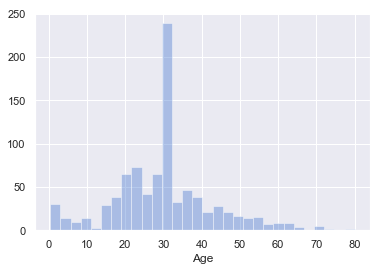

In [54]:
# visualise age distribution
sns.distplot(df['Age'], kde=False)
plt.show()

In [55]:
# convert to age categories
bins = [0, 6, 20, 40, 60, 100]
group_names = ['<=6', '7-20', '21-40', '41-60', '60+']
df['age_cats'] = pd.cut(df['Age'], bins, labels=group_names, include_lowest=True)
# drop old age column
df.drop('Age', axis=1, inplace=True)

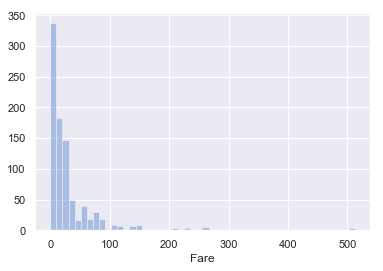

In [56]:
# visualise fare distribution
sns.distplot(df['Fare'], kde=False)
plt.show()

In [57]:
# most people paid under 100 dollars so let's split them as follows
bins = [0, 25, 50, 75, 100, 1000]
group_names = ['<=25', '26-50', '51-75', '76-100', '100+']
df['fare_cats'] = pd.cut(df['Fare'], bins, labels=group_names, include_lowest=True)
# drop old age column
df.drop('Fare', axis=1, inplace=True)

In [58]:
# calculate entropy of survival
entropy_parent = entropy(df['Survived']); entropy_parent

0.9607079018756469

In [59]:
rank_info_gain = []

for col in df.drop(['Survived'], axis=1).columns:
    rank_info_gain.append({'Attribute': col, 'Information Gain': information_gain(entropy_parent, col, 'Survived')}) 

In [60]:
df_info_gain = pd.DataFrame.from_dict(rank_info_gain).sort_values(by='Information Gain', ascending=False)

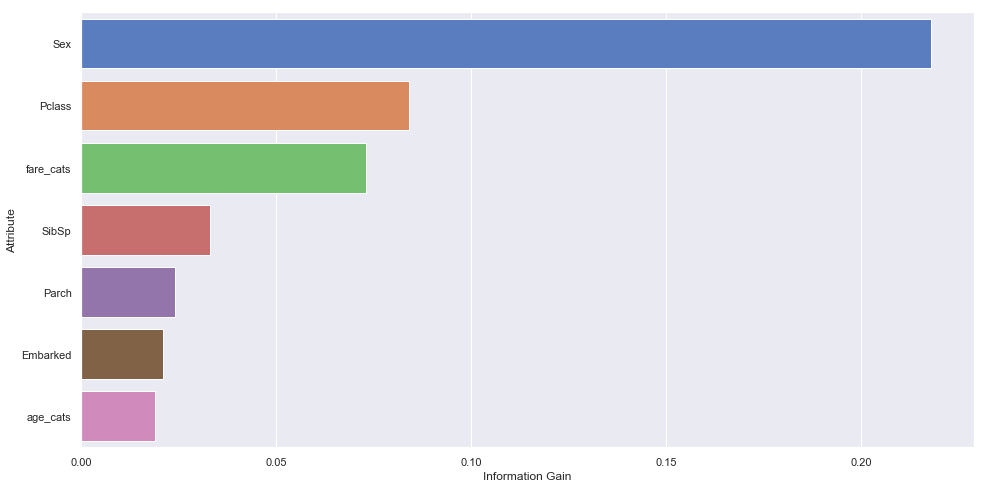

In [61]:
plt.figure(figsize=(16,8))
sns.barplot(x='Information Gain', y='Attribute', data=df_info_gain)
plt.show()

Evidently the gender of the passengers is the most informative attribute for predicting survival on the titanic or not.

In [62]:
def survival_plot(column):
    sns.countplot(x=column, hue='Survived', data=df)
    # place the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Survived')
    plt.show()

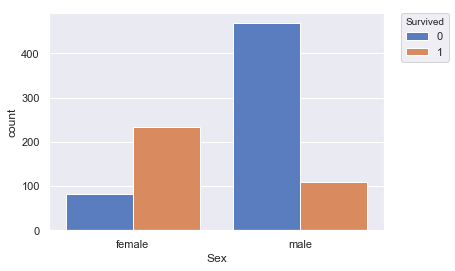

In [63]:
survival_plot('Sex')

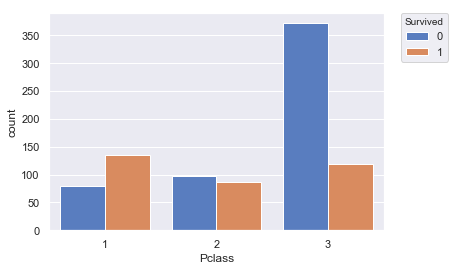

In [64]:
survival_plot('Pclass')

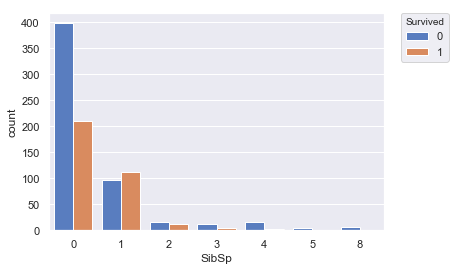

In [65]:
survival_plot('SibSp')

In [66]:
model = DecisionTreeClassifier(max_depth=3, criterion='entropy')
# display the full set of hyperparameters
model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
for col in df.select_dtypes(include='category'):
    df[col] = df[col].cat.codes

In [73]:
X = df.drop(['Survived'], axis=1)

# convert categories to codes
for col in X.select_dtypes(include='category'):
    X[col] = X[col].cat.codes
    
X.shape

(891, 7)

In [74]:
y = df['Survived']
y.shape

(891,)

In [75]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

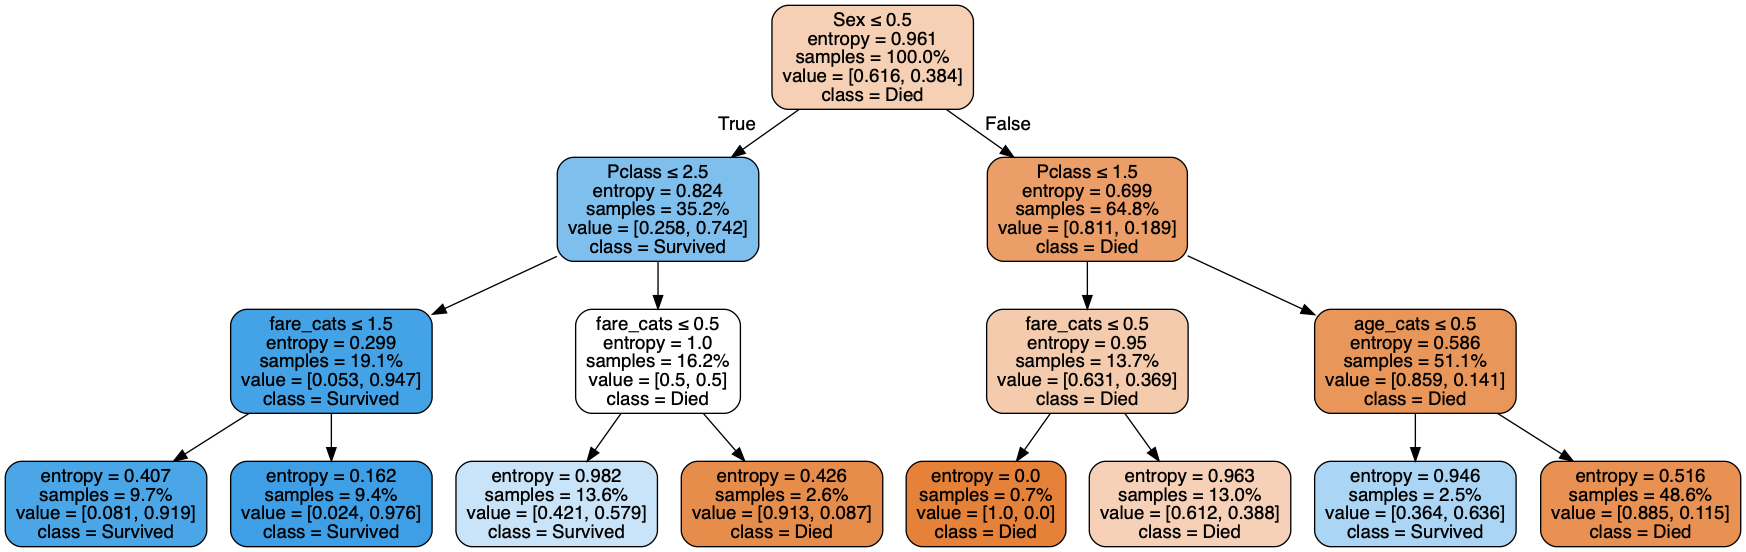

In [76]:
visualise_tree(model, X.columns, ['Died','Survived'])

The most important features are: gender, passenger class, fare, and age.